## GW Rates Estimators

In this notebook, I test several implementations of the statistical methodology presented in the paper "Counting and Confusion: Bayesian Rate Estimation with Multiple Populations" by Farr, Gair, Mandel, & Cutler, colloquially known as FGMC.

This methology allows you to infer the rate of astrophysical events (as opposed to background triggers) detected by gravitational-wave observatories, given a set of triggers with known signal to noise ratios (SNRs). 

In [1]:
import corner
import emcee
import gwrates.rates_tools as rt
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erfc, erfinv
from scipy import stats

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# FGMC with two classes
Test FGMC when all samples are categorized as either foreground or background. There are no subdivisions of either category.

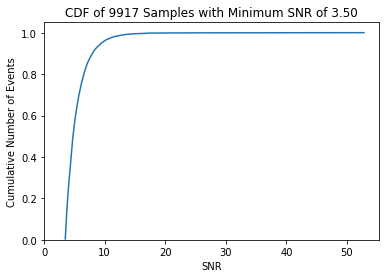

In [2]:
# Set known parameters (Example 1 of FGMC paper)
num_samples = 10000
# rate_f = 10.4
# rate_b = 95.1

# FIXME: change SampleCollections to require num samples to be rate_f + rate_b
rate_f = 1930
rate_b = num_samples - rate_f
xmin = 3.5

collection = rt.SampleCollection(rate_f, rate_b, xmin)
collection.draw_samples(num_samples)
#collection.plot_hist()
collection.plot_cdf()


## MCMC to recover two classes
Use an MCMC to with the FGMC methodology to find the underlying rates of foreground and background events.

In [18]:
reload(rt)
# Draw from overall samples, assuming we don't know R_f and R_b
all_samples = np.concatenate((collection.foreground, collection.background))

pos_true = [rate_f, rate_b]

ndim = 2
nwalkers=100

# Make initial guesses with dimensions (2 x nwalkers) -- FIXME: do this better
pos_init = [100 * np.random.rand(ndim) for i in np.arange(nwalkers)]

# Pre evaluate our samples on the model PDFs
# FIXME: Have collection evaluate models for you
model_values = (rt.power_law_pdf(all_samples, -4, xmin), rt.chi2_xmin_pdf(all_samples, 2, xmin))

np.seterr(invalid='raise')

sampler = emcee.EnsembleSampler(nwalkers, ndim, rt.lnprob, args=[model_values, xmin])    
pos, _, _ = sampler.run_mcmc(pos_init, 2000)
post_samples = sampler.chain[:, 50:, :].reshape((-1, ndim))    


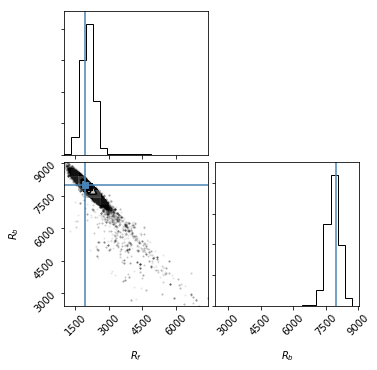

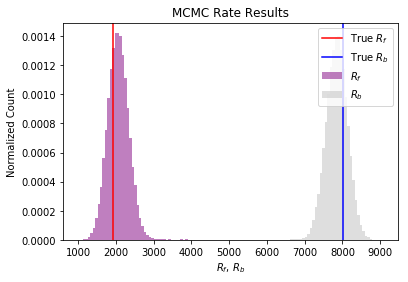

In [19]:
true_f = len(all_samples) * rate_f / (rate_f + rate_b)
true_b = len(all_samples) * rate_b / (rate_f + rate_b)

fig = corner.corner(post_samples, labels=["$R_f$", "$R_b$"], truths=[true_f , true_b])    

# plt.figure()
# plt.plot(sampler.chain[:, 50:, 0], color='k', alpha=0.2)
# plt.show()


# plt.figure()
# plt.plot(sampler.chain[:, 50:, 1], color='k', alpha=0.2, lw=0.5)
# plt.show()

plt.figure()
plt.hist(post_samples[:,0], bins=100, label=r'$R_{f}$', color='purple', alpha=0.5, normed=True)
plt.hist(post_samples[:,1], bins=100, label=r'$R_{b}$', color='0.75', alpha=0.5, normed=True)
plt.axvline(x=true_f, c='r', label=r'True $R_{f}$')
plt.axvline(x=true_b, c='b', label=r'True $R_{b}$')
plt.xlabel(r'$R_f$, $R_b$')
plt.ylabel('Normalized Count')
plt.title('MCMC Rate Results')
plt.legend(loc='upper right')
#plt.xlim(0,140)
plt.show()


## Gravity Spy
In this section, we obtain labels for the excess noise provided by the gravity spy system. Excess noise is identified by the Omicron algorithm that uses wavelets (i.e. sine-gaussians) for identifying excess noise. Therefore, the more a background excess noise event looks like a sine-gaussian the louder the SNR. In addition, restrictions of peak_frequency and SNR were supplied to Gravity Spy data. We only take Omicron triggers with a signal-to-noise ratio of 7.5 and greater and a peak_frequency between 10 and 2048.

These labels will need to be run over with a templated match filter. Of especial interest will be blip and scratch type excess noise.

This effort will be in parallel with finishing a study started so kindly by Laura Nutall and TJ Massinger about comparing omicron and pyCBC match filter values as well as running gravit spy over said events to get a "safety" check of sorts.

Individual Template Example:

https://ldas-jobs.ligo.caltech.edu/~thomas.massinger/detchar/CBC/CBC_Omicron/IMBH-SEOBRv4/IMBH-SEOBNRv4-newSNR-SNR.pdf

All Templates:
https://ldas-jobs.ligo.caltech.edu/~thomas.massinger/detchar/CBC/CBC_Omicron/

This section saves to one h5 file trigger info for human vetted and only machine learning vetted labels. The group is /humn

In [ ]:
from gwpy.table import EventTable

# list all possible labels
gravityspy_classes =  ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 
                       'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 
                       'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 
                       'No_Glitch', 'None_of_the_Above', 'Paired_Doves', 'Power_Line', 
                       'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte', 
                       'Violin_Mode', 'Wandering_Line', 'Whistle']

# Now we determine what types of labels we want: ML or ML + human
label_types = {'human':'Retired', 'machinelearning': '0.9'}

# what metadata do we want
columns = ['snr', 'Label', 'peakGPS']

for iclass in gravityspy_classes:
    for itype in label_types.keys():
        if itype == 'human':
            tmp_table = EventTable.fetch('gravityspy',
                                         'glitches WHERE \"Label\" = \'{0}\' AND \"ImageStatus\" = \'Retired\''.format(
                                             iclass),
                                         columns=columns)
        elif itype == 'machinelearning':
            tmp_table = EventTable.fetch('gravityspy',
                                         'glitches WHERE \"Label\" = \'{0}\' AND \"{0}\" > {1}'.format(
                                             iclass, label_types[itype]),
                                         columns=columns)

        tmp_table['Label'] = tmp_table['Label'].astype(str)
        tmp_table.write('gspytrigger.hdf5', path='{0}/{1}'.format(itype, iclass), format='hdf5', append=True)

## Transforming Gravity Spy classes into realization of the background
For simplicity the above command has already been run and the hdf5 file exist in the `etc` folder in this repo. In this next chunk we create a nice `EventTable` which is just a glorified `astropy` table of all of the gravityspy triggers. Columns are `peakGPS`, `snr` and `Label`

In [2]:
from gwpy.table import EventTable
from astropy.table import vstack

gravityspy_classes =  ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 
                       'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 
                       'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 
                       'No_Glitch', 'None_of_the_Above', 'Paired_Doves', 'Power_Line', 
                       'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte', 
                       'Violin_Mode', 'Wandering_Line', 'Whistle']

background = []
# Read in gravityspy machine learning labels
for iclass in gravityspy_classes:
    background.append(EventTable.read('etc/gspytrigger.hdf5', path='human/{0}'.format(iclass), format='hdf5'))
    
background = vstack(background)
background = EventTable(background)
background

/Users/scottcoughlin/Documents/virtualenvs/gwrates/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


snr,Label,peakGPS
float64,str19,float64
8.41837978363037,1080Lines,1165805734.23828
12.9874296188354,1080Lines,1164295437.81641
11.078519821167,1080Lines,1166330508.29297
9.01434993743896,1080Lines,1164729207.10547
8.48991012573242,1080Lines,1165645281.86328
9.5882396697998,1080Lines,1164597734.52734
8.77915000915527,1080Lines,1163482835.59961
8.08469009399414,1080Lines,1164466968.03516
9.13422012329102,1080Lines,1165511068.15234


Now that we have this table we simply do some fun pandas operations to get two dicts.

`counts_of_each_cass` : a dictionary with keys of glitch classes and values of counts of that class

`snr_series_of_each_class` : a dictionary with keys of glitch classes and values of snr series

In [3]:
# Turn the EventTable into a pandas table for easy dict manipulation
background = background.to_pandas()

# Convert labels to strings
background['Label'] = background['Label'].str.decode('utf-8')

#bg_events = background.loc[background.Label.isin(['Scratchy', 'Tomte'])]
bg_events = background

counts_of_each_class = bg_events.Label.value_counts().to_dict()
snr_series_of_each_class = bg_events.groupby('Label').apply(lambda x: x['snr'].tolist()).to_dict()
total_background_count = sum(counts_of_each_class.values())

total_background_count, counts_of_each_class, snr_series_of_each_class



(52941,
 {u'1080Lines': 5418,
  u'1400Ripples': 920,
  u'Air_Compressor': 9,
  u'Blip': 8822,
  u'Chirp': 6,
  u'Extremely_Loud': 1002,
  u'Helix': 5,
  u'Koi_Fish': 1361,
  u'Light_Modulation': 56,
  u'Low_Frequency_Burst': 7766,
  u'Low_Frequency_Lines': 8443,
  u'No_Glitch': 37,
  u'None_of_the_Above': 1091,
  u'Paired_Doves': 6,
  u'Power_Line': 1643,
  u'Repeating_Blips': 242,
  u'Scattered_Light': 9557,
  u'Scratchy': 1031,
  u'Tomte': 111,
  u'Violin_Mode': 4587,
  u'Wandering_Line': 23,
  u'Whistle': 805},
 {u'1080Lines': [8.41837978363037,
   12.9874296188354,
   11.078519821167,
   9.01434993743896,
   8.48991012573242,
   9.5882396697998,
   8.77915000915527,
   8.08469009399414,
   9.13422012329102,
   7.82938003540039,
   8.9225902557373,
   7.77264022827148,
   7.61624002456665,
   7.93404006958008,
   9.3590202331543,
   9.86631965637207,
   8.50967025756836,
   10.5601797103882,
   13.6372404098511,
   12.5055303573608,
   8.48262023925781,
   9.47373962402344,
   9.050

## Selecting foreground samples, background samples, and glitch class samples
Here you provided how many total samples, foreground samples you want, and because the glitch class samples are already selected for you then the leftover determines the gaussian background samples.

In [4]:
# User selects total number of gaussian and foreground events
foreground_count = 9300
gaussian_background_count = 20558


print(foreground_count + gaussian_background_count + counts_of_each_class['Scratchy'] + counts_of_each_class['Blip'])

39711


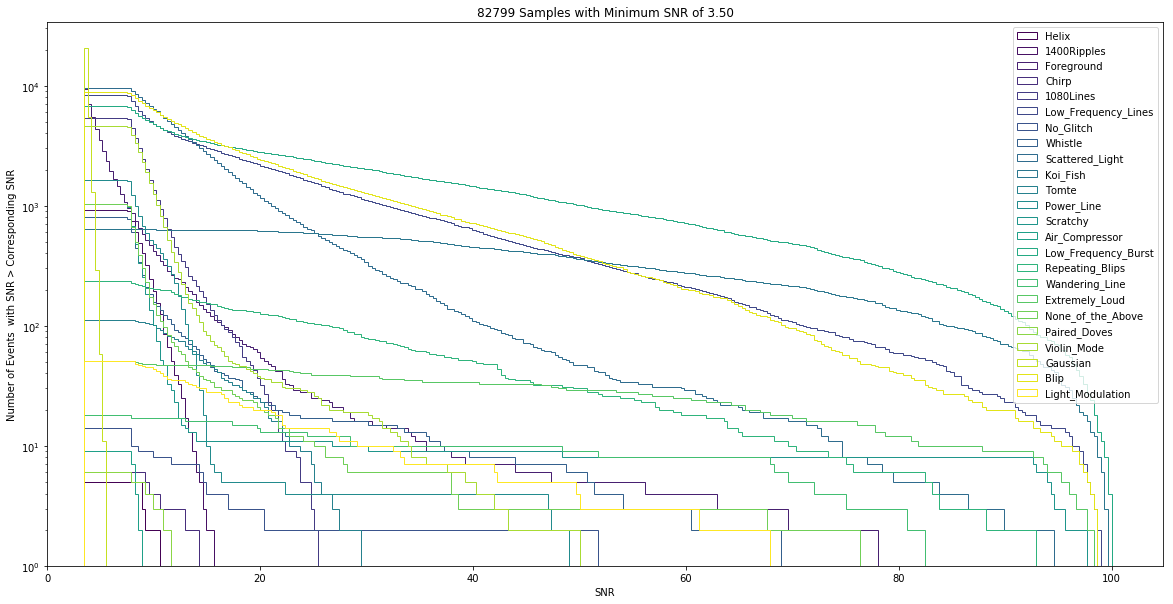

In [5]:
collection = rt.ManyBackgroundCollection(snr_series_of_each_class)
collection.draw_samples(foreground_count, gaussian_background_count)
collection.plot_hist()

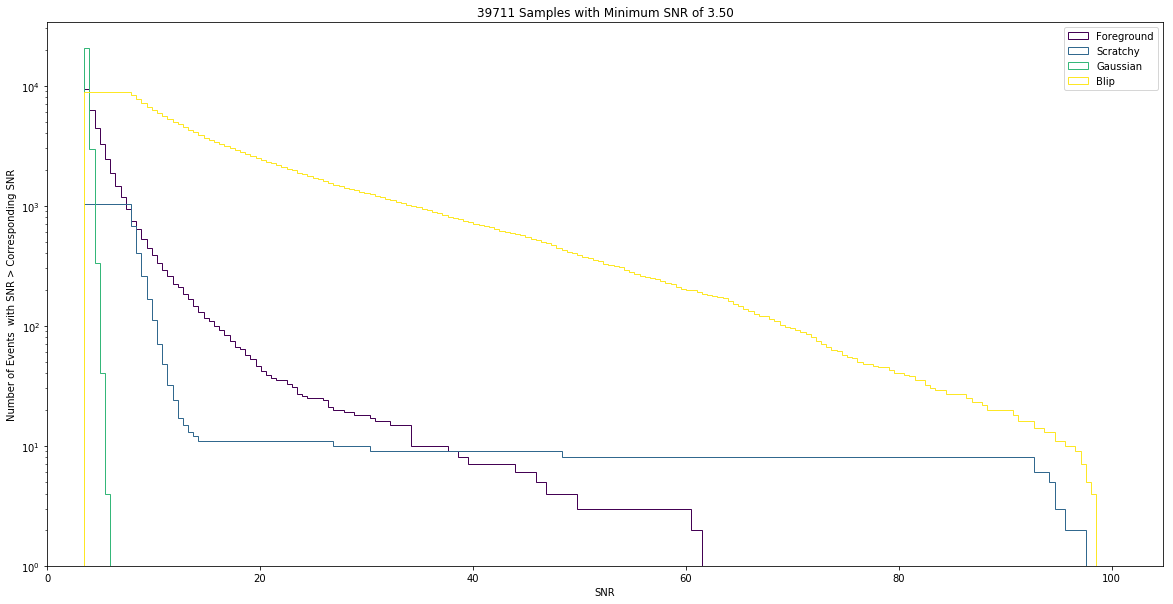

In [6]:
collection.draw_samples(foreground_count, gaussian_background_count, glitch_classes=['Scratchy', 'Blip'])
collection.plot_hist()

## Compute KDE for each Gravity Spy Glitch 
This produces a dictionary of KDE objects for each GravitySpy glitch class. All KDEs are computed through identical methods. These will later be used to evaluate the likelihood of a certain SNR trigger coming from a certain glitch distribution.

In [7]:
# Compute KDE for each glitch type
from sklearn.neighbors import KernelDensity
    
def compute_kde(glitch_type):
    
    """
    Compute a KDE for a given set of SNRs for a glitch.
    
    Parameters:
    -----------
    glitch_type: string
        identified for GravitySpy glitch class
        
    Returns:
    --------
    kde_skl: scikit-learn KernelDensity object
        fit KDE for a given glitch class
    """
    
    
    # Make KDE of one gravity spy distribution
    kde_skl = KernelDensity(bandwidth=1)
    kde_skl.fit(np.asarray(snr_series_of_each_class[glitch_type]).reshape(-1, 1))
    
    return kde_skl

def plot_kde(glitch_type):
    
    """
    Plot a KDE of a GravitySpy glitch SNR distribution
    over the analogous histogram.
    
    Parameters:
    -----------
    glitch_type: string
        identified for GravitySpy glitch class
    """

    
    xrange = np.linspace(7.5, 100, 100)
    kde = glitch_kdes[glitch_type]
    pdf = np.exp(kde.score_samples(xrange.reshape(-1, 1)))

    plt.figure()
    plt.hist(snr_series_of_each_class[glitch_type], bins=xrange, normed=True)
    plt.plot(xrange, pdf, color='r')
    plt.xlim(0,100)
    plt.show()
    
glitch_kdes = {}
for glitch_type in gravityspy_classes:
    glitch_kdes[glitch_type] = compute_kde(glitch_type)

#plot_kde('Blip')

## MCMC
Use an MCMC to recover the true number of each source category in a set of unlabeled triggers.

In [8]:
# Set array of true counts for each category
counts_true = []
#for key in collection.samples.keys():
for key in ['Foreground', 'Gaussian', 'Scratchy', 'Blip']:
    counts_true.append(len(collection.samples[key]))
    if key =='Foreground':
        setattr(collection, key + '_evaluted', 3 * collection.xmin**3 * collection.unlabeled_samples**(-4))
    elif key == 'Gaussian':
        setattr(collection, key + '_evaluted', (np.sqrt(np.pi/2) * erfc(
                collection.xmin / np.sqrt(2)))**(-1) * np.exp(
                -collection.unlabeled_samples**2 / 2))
    else:
        setattr(collection, key + '_evaluted', np.exp(glitch_kdes[key].score_samples(collection.unlabeled_samples.reshape(-1,1))))
counts_true = np.asarray(counts_true)
print(counts_true)

[ 9300 20558  1031  8822]


In [9]:
getattr(collection, key + '_evaluted')

array([6.84567552e-05, 1.21010973e-05, 9.76565028e-02, ...,
       7.60749664e-02, 9.72210638e-02, 1.43279187e-02])

In [ ]:
ndim = len(collection.samples)
nwalkers=100

pos_init = [collection.num_samples * np.random.rand(ndim) for i in np.arange(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, collection.lnprob, 
                                args=([['Scratchy', 'Blip']]))    
sampler.run_mcmc(pos_init, 100)  
post_samples = sampler.chain[:, :, :].reshape((-1, ndim)) 

> /Users/scottcoughlin/Documents/GitHub/gw_rates/gwrates/rates_tools.py(260)lnlike()
-> return np.sum(np.log(fg_likelihood + gauss_likelihood + \
(Pdb) glitch_classes
['Scratchy', 'Blip']
(Pdb) glitch_likelihood
array([1.27729832e+01, 2.29584783e+00, 1.05911800e+04, ...,
       1.94227519e+03, 1.06134807e+04, 1.51344378e+01])


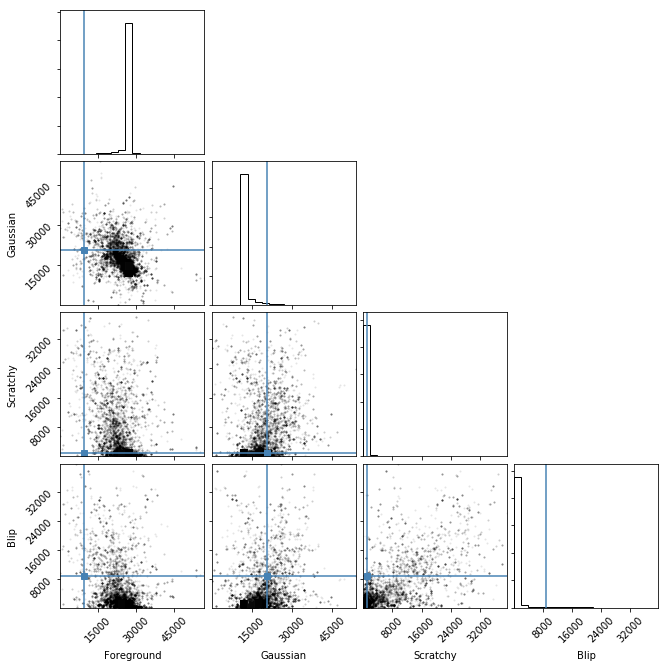

In [13]:
fig = corner.corner(post_samples, 
                    labels=["Foreground", "Gaussian", "Scratchy", "Blip"], 
                    truths=counts_true)    